# Organization of the Petroleum Exporting Countries
### Petroleum is essential to operate boats and it is wise to analyze the varying price flucuations. 
#### Data Source:https://data.nasdaq.com/data/OPEC-organization-of-the-petroleum-exporting-countries

# Table of Contents 
## 1. Importing Libraries and Data 
## 2. Data Wrangling
## 3. Decomposing of the data for time-series analysis
## 4. Testing for stationarity
## 5. Stationarizing the Data

# 1. Importing Libraries and Data 

In [33]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [34]:
# Configure API key 

quandl.ApiConfig.api_key = '6EJjZUxc4F2_EdLpGQxy'

In [35]:
# Importing the Quandl data.

data = quandl.get('OPEC/ORB')

In [36]:
data.head(5)

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [37]:
data.shape

(5179, 1)

In [38]:
data.columns

Index(['Value'], dtype='object')

In [39]:
type(data)

pandas.core.frame.DataFrame

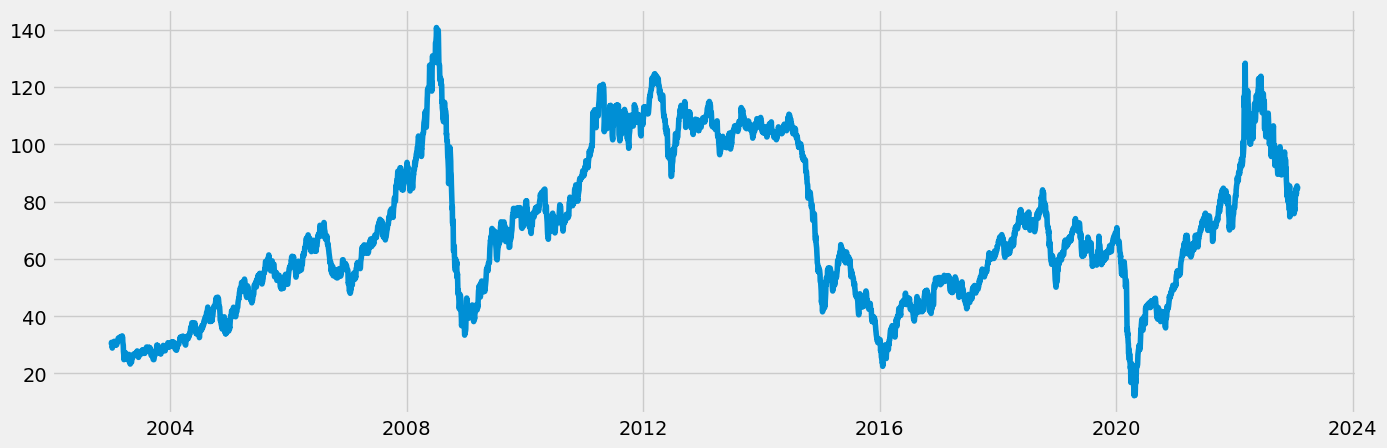

In [40]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

## Too many data points. Requires some smoothing.

# 2. Data Wrangling

In [41]:
# Smooth Moving Average for the data (30 days)
data['SMA'] = data['Value'].rolling(30).mean()

In [42]:
data.dropna(inplace = True)

In [43]:
data.head()

,Value,SMA
Date,,
2003-02-12,31.30,30.474667
2003-02-13,31.91,30.536667
2003-02-14,32.33,30.586667
2003-02-17,31.90,30.626333
2003-02-18,31.85,30.697333


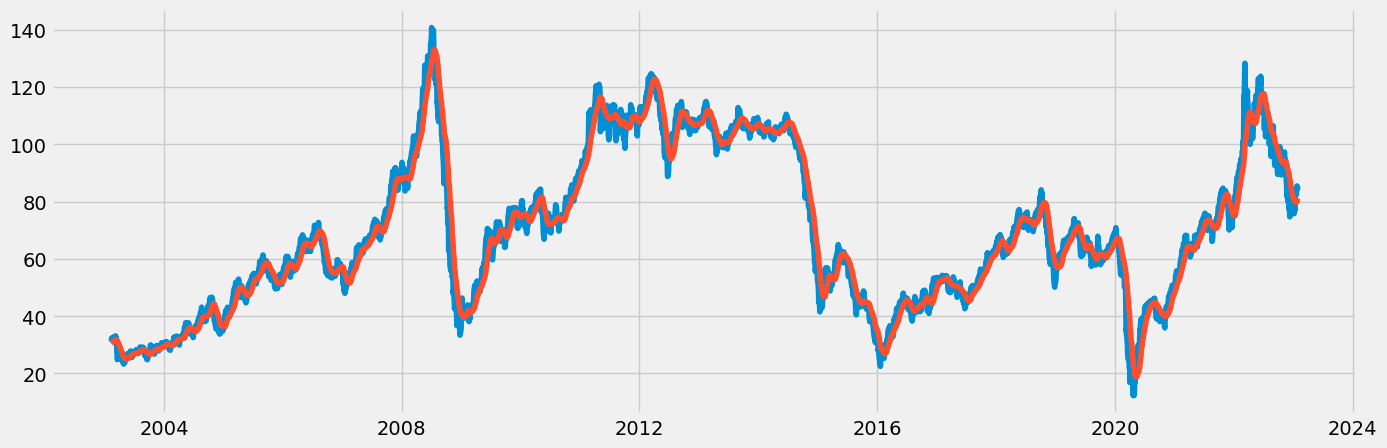

In [44]:
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

## There is less noise pn the smotthing curve so thats the one that would be used

# Subsetting, wrangling, and cleaning time-series data

In [45]:
# Reset index so that you can use the "Date" column as a filter
data = data.reset_index()

In [46]:
# Extract month from the 'Date' column in the dataframe
data['Month'] = pd.DatetimeIndex(data['Date']).month

In [47]:
# Extract year from the 'Date' column in the dataframe
data['Year'] = pd.DatetimeIndex(data['Date']).year

In [48]:
# Creating a new column with year and month combined
data['Date_new'] = pd.to_datetime(data.Year.astype(str) + '-' + data.Month.astype(str))

In [49]:
data.head() 

,Date,Value,SMA,Month,Year,Date_new
0,2003-02-12,31.30,30.474667,2,2003,2003-02-01
1,2003-02-13,31.91,30.536667,2,2003,2003-02-01
2,2003-02-14,32.33,30.586667,2,2003,2003-02-01
3,2003-02-17,31.90,30.626333,2,2003,2003-02-01
4,2003-02-18,31.85,30.697333,2,2003,2003-02-01


In [50]:
# Creating a new dataframe with median value grouped by 'Date_new'
data_group = data.groupby('Date_new').agg({'SMA': ['median']})

In [51]:
data_group.shape

(240, 1)

In [52]:
data_group.head(5)

,SMA
,median
Date_new,
2003-02-01,30.866000
2003-03-01,31.451667
2003-04-01,27.851000
2003-05-01,25.182333
2003-06-01,26.355667


## The 'Date_new'column is already set as index

In [53]:
data_group.dtypes

SMA  median    float64
dtype: object

In [54]:
# Check for missing values 

data_group.isnull().sum() 

SMA  median    0
dtype: int64

In [55]:
# Check for duplicates

dups = data_group.duplicated()
dups.sum()

0

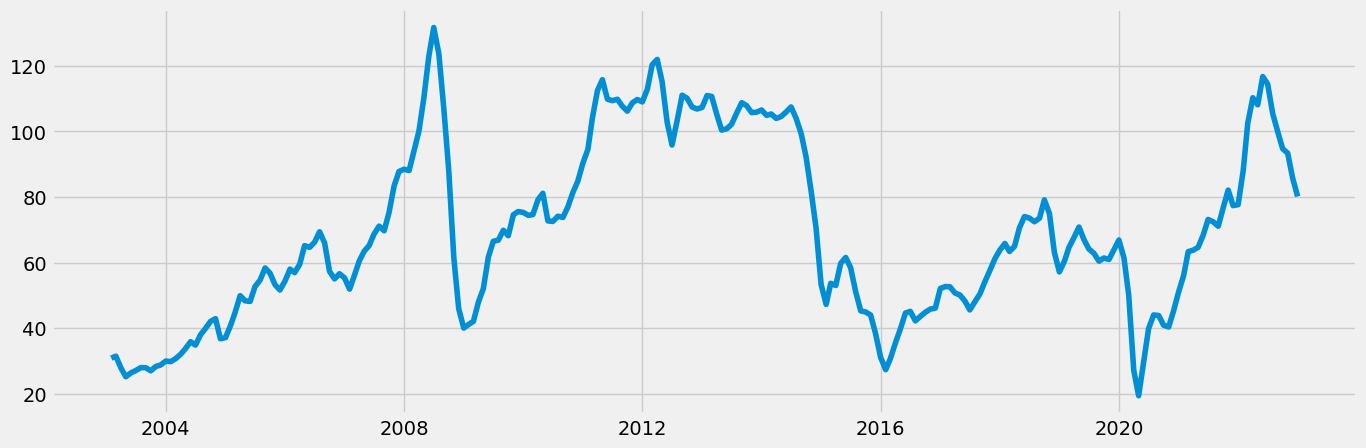

In [56]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_group)

In [57]:
data_group.columns

MultiIndex([('SMA', 'median')],
           )

# 3. Decomposing of the data for time-series analysis

In [58]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(x = data_group, model='additive')

In [59]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

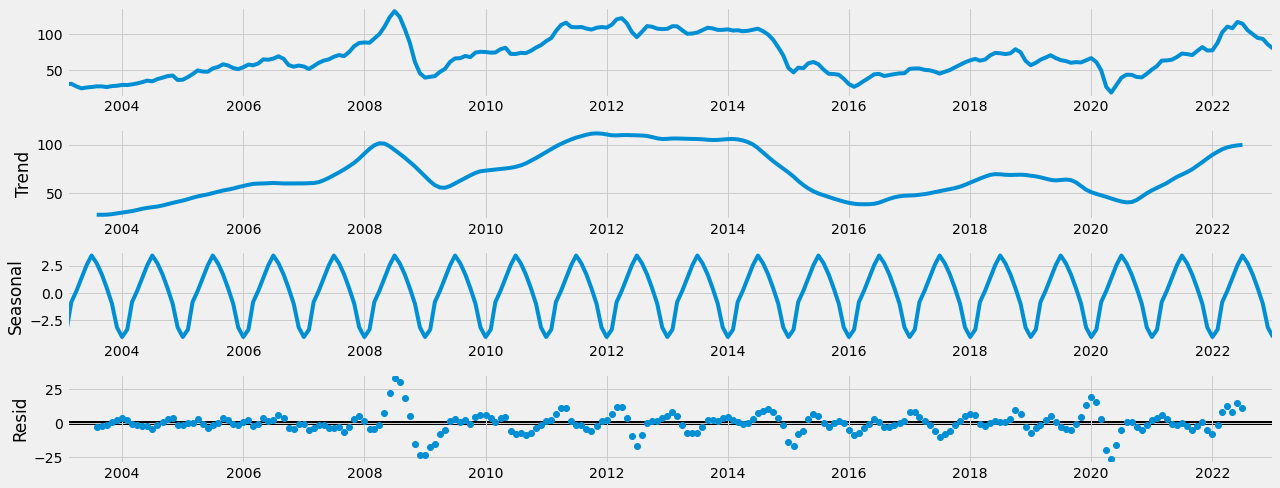

In [60]:
# Plot the separate components

decomposition.plot()
plt.show()

The plot shows seasonality due to a pattern repeating itself at the same time each year. Notable fluctations are th 2008 recession and the 2020 COVID-19 pandemic.

# 4. Testing for stationarity

## A. Dickey-Fuller Test

In [61]:
# The adfuller() function will import from the model from statsmodels for the test; however, 
# running it will only return an array of numbers. 
# This is the resaon to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_group['SMA'])


Dickey-Fuller Stationarity test:
Test Statistic                  -2.707449
p-value                          0.072758
Number of Lags Used              2.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


The null hypothesis cannot be rejected as the “Critical Value of 5% has a value of -2.873814 and is smaller than the Test Statistic of -2.707449. The data is non-stationary.

# B. Autocorrelation Test

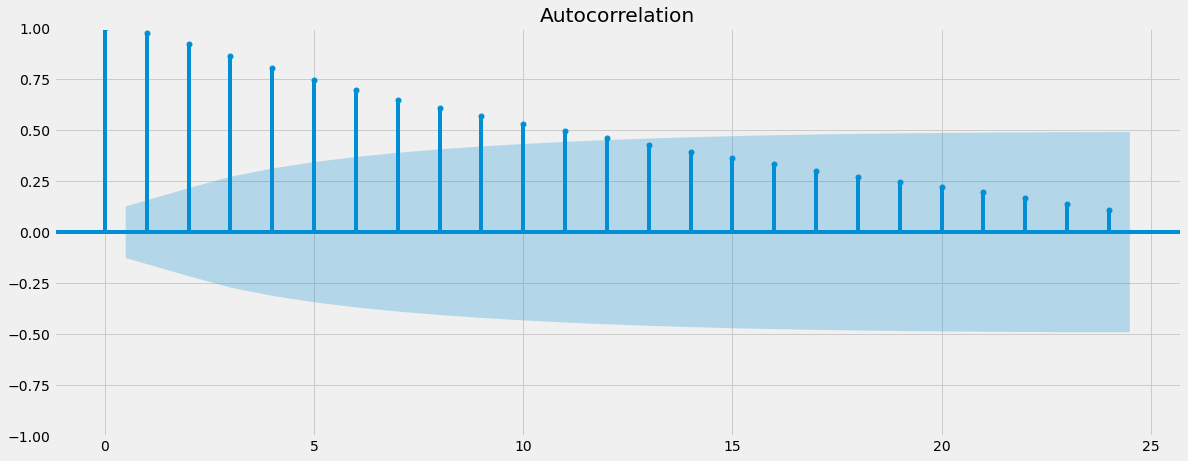

In [62]:
# Checking plot of autocorrelation

# Importing the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_group)
plt.show()

The data is non-stationary. The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags that are significantly correlated with each other. 

# 5. Stationarizing the Data

In [63]:
# Conducting the first round of differencing by subtracting the previous data point from the current data point
# The df.shift(1) function turns the observation to t-1, making the whole data t - (t -1)

data_diff = data_group - data_group.shift(1)

In [64]:
# Removing missing values as a result of differencing

data_diff.dropna(inplace = True)

In [65]:
# Checking values and headers

data_diff.head()

,SMA
,median
Date_new,
2003-03-01,0.585667
2003-04-01,-3.600667
2003-05-01,-2.668667
2003-06-01,1.173333
2003-07-01,0.711667


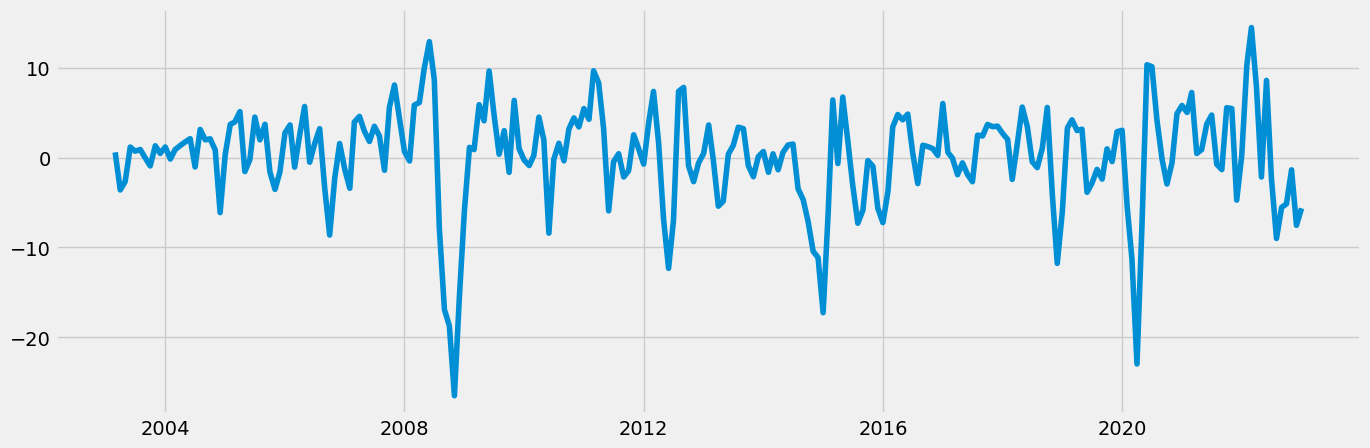

In [66]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [67]:
# Re-running the Dickey-Fuller Test to check for stationarity

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.424752e+00
p-value                        5.384002e-16
Number of Lags Used            1.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


The null hypothesis can be rejected. The test statistic value (-9.424752) is smaller than the critical value (5%) of -2.873814 and the p-value is smaller than 0.05. The data is now stationary. 

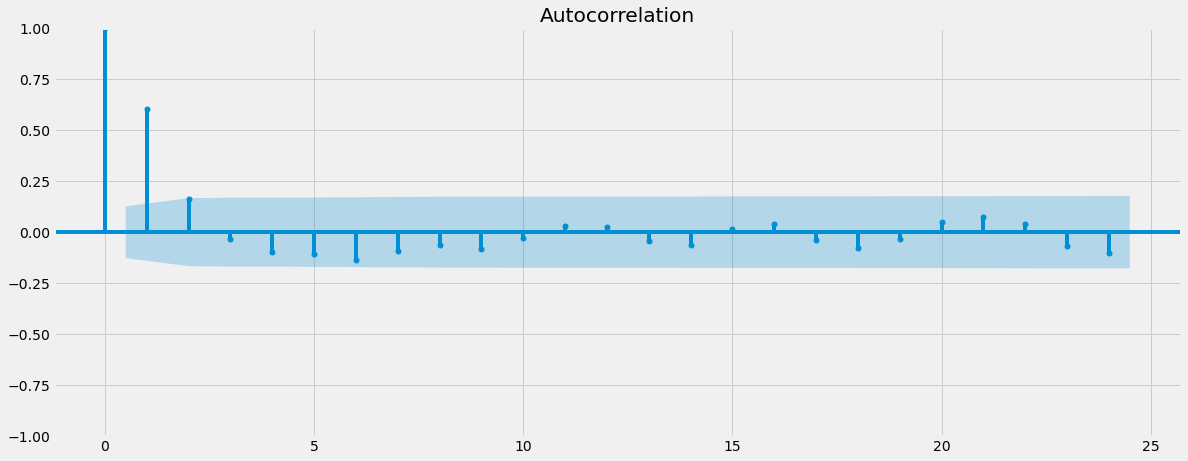

In [68]:
# Plotting the autocorrelation again

plot_acf(data_diff)
plt.show()

The vertical lines are below the confidence interval except one meaning the stationary is strong. 